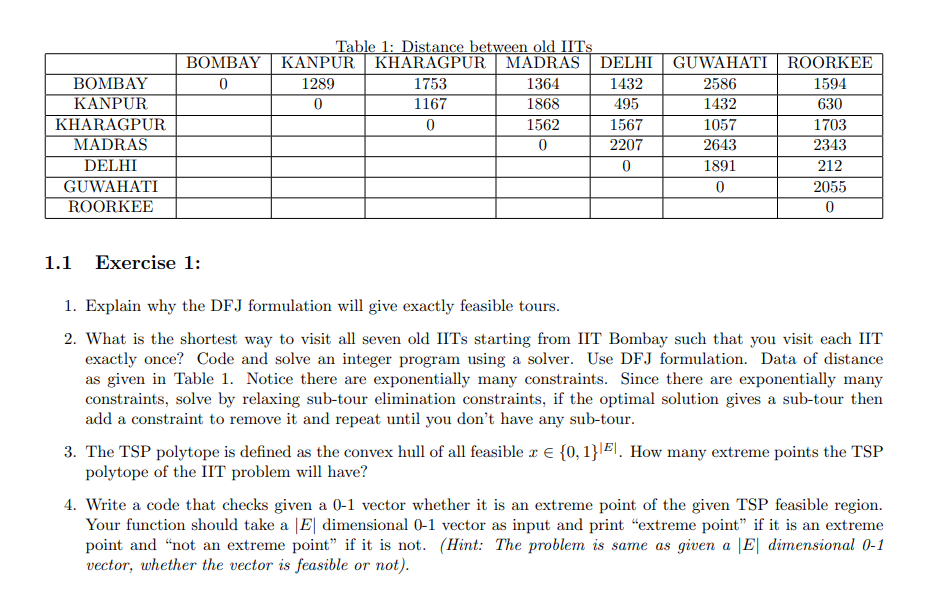

#Question 1

The Travelling Salesman Problem (TSP) ensures that the solutions it produces are exactly feasible tours by incorporating specific constraints that enforce the properties of a valid tour. Let's break down these constraints:

**Every city is visited once and left once:**

The constraint
$∑​xe​=2∀i∈V
∀e∈δ(i)$
ensures that every city is visited exactly once and left exactly once. Here, δ(i) represents the set of edges incident on vertex i. So, for each city i, exactly two edges are selected, indicating that the salesman enters and leaves the city exactly once.

**Elimination of sub-tours:**

The constraint
$∑​xe​≥2∀ϕ⊂S⊂V
∀e∈δ(S)$
ensures that there are no sub-tours in the solution. For any subset S of vertices (excluding the entire set V and the empty set), the sum of selected edges e∈δ(S) incident on vertices in **S is greater than or equal to 2**. This ensures that every subset of vertices has at least one edge incident on it, preventing the formation of disconnected sub-tours.

**Binary variable constraints:**
The binary constraint
$xe∈({0,1})$∀e∈E

These constraints together enforce that the solution consists of a Hamiltonian cycle, visiting each city exactly once and returning to the starting city, without any sub-tours or unused edges. Therefore, any solution obtained by solving the DFJ formulation will indeed correspond to a feasible tour for the TSP.


## Dantzig, Fulkerson and Johnson (DFJ) Formulation

Consider the following formulation of the *symmetric traveling salesman
problem* due to Dantzig, Fulkerson and Johnson, 1954 (DFJ) that we have
been discussing during the course. Let $V=\{0..n-1\}$ be the set of nodes
and $E$ the set of edges. Let $E(S)$ be the set of edges induced by the
subset of vertices $S$ and $\delta(v)$ the set of edges in the cut
$(v,V\setminus\{v\})$. (We will assume that the instance is symmetric and that an edge between two nodes $i$ and $j$ is present in $E$ only in the form $ij$, if $j>i$, or $ji$, if $ j < i$.)
$$
\begin{aligned}
\text{(TSPIP)}\quad \min\; & \sum c_{ij} x_{ij} \\
\text{s.t.}\;&\sum_{ij \in \delta(i)} x_{ij}+\sum_{ji \in \delta(i)}x_{ji}=2 \text{ for all } i \in V\\
&\sum_{ij \in E(S)} x_{ij} \leq |S|-1 \text{ for all } \emptyset \subset S\subset V, 2 \leq |S| \leq n-1\\
&x_{ij} \in \{0,1\} \text{ for all } {ij} \in E
\end{aligned}
$$

#Question 2

In [5]:
!pip install pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq glpk
!pip install -i https://pypi.gurobi.com gurobipy


E: Unable to locate package glpk
Looking in indexes: https://pypi.gurobi.com


In [6]:
import numpy as np

# Distance matrix from the provided table
distance_table = [
    [0, 1289, 1753, 1364, 1432, 2586, 1594],
    [1289, 0, 1167, 1868, 495, 1432, 630],
    [1753, 1167, 0, 1562, 1567, 1057, 1703],
    [1364, 1868, 1562, 0, 2207, 2643, 2343],
    [1432, 495, 1567, 2207, 0, 1891, 212],
    [2586, 1432, 1057, 2643, 1891, 0, 2055],
    [1594, 630, 1703, 2343, 212, 2055, 0]
]

# Convert the table into a numpy array
costMatrix = np.array(distance_table)

In [7]:
import pyomo.environ as pyo
import numpy as np
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#define the TSP_DFJ
def TSP_DFJ_Formulation(n, costMatrix):
    # 1 | initialize sets and notations
    N0 = [i for i in range(0,n+1)]
    N = [i for i in range(1,n)]
    arc_IJ = [(i,j) for i in N0 for j in N0 if i!=j]
    c = {(i,j) : costMatrix[i-1][j-1] for (i,j) in arc_IJ}

    # 2 | initialize the model
    model = pyo.ConcreteModel()

    # 3 | initialize decision variables
    model.x = pyo.Var(arc_IJ, within=pyo.Binary)

    # 4 | define objective function
    model.objective = pyo.Objective(
        expr= sum(model.x[i,j]*c[i,j] for (i,j) in arc_IJ),
        sense=pyo.minimize)

    # 5 | define constraints
    model.constraints = pyo.ConstraintList()

    # a) each node is visited only once (restrict the inbound arc to 1)
    for j in N:
        model.constraints.add(sum([model.x[i,j] for i in N0 if i!=j]) == 1)

    # b) each node is visited only once (restrict the outbound arc to 1)
    for i in N:
        model.constraints.add(sum([model.x[i,j] for j in N0 if i!=j]) == 1)

    # c) subtour elimination constraints
    SubtourSet = list(powerset(N0))[1:-1]
    for S in SubtourSet:
        if len(S) >= 2:
            model.constraints.add(sum([model.x[i,j] for i in S for j in S if i!=j]) <= len(S)-1)

    # 6 | call the solver (we use Gurobi here, but you can use other solvers i.e. PuLP or CPLEX)
    model.pprint()
    solver = pyo.SolverFactory('gurobi')
    completeResults = solver.solve(model,tee = True)

    # 7 | extract the results
    solutionObjective = model.objective()
    tourRepo = []
    for i in model.x:
        if model.x[i].value > 0:
            tourRepo.append((i, model.x[i].value))
            print(str(model.x[i]), model.x[i].value)
    solutionGap = (completeResults.Problem._list[0]['Upper bound'] - completeResults.Problem._list[0]['Lower bound']) / completeResults.Problem._list[0]['Upper bound']
    runtimeCount = completeResults.Solver._list[0]['Time']

    return solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults


# number of nodes on the graph, can be calculated as the horizontal/vertical length of the distance matrix
n = len(costMatrix[0:])

solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults = TSP_DFJ_Formulation(n, costMatrix)



1 Var Declarations
    x : Size=56, Index={(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 5) :     0 :  None :     1 : False :  True : Binary
        (0, 6) :     0 :  None :     1 : False :  True : Binary
        (0, 7) :     0 :  None :     1 : False :  True : Bina

In [8]:
import pyomo.environ as pyo
import numpy as np
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def TSP_DFJ_Formulation(n, costMatrix, start_node):
    # Initialize sets and notations
    N0 = [i for i in range(1, n + 1)]  # Nodes (1-indexed)
    arc_IJ = [(i, j) for i in N0 for j in N0 if i != j]  # Arcs
    c = {(i, j): costMatrix[i - 1][j - 1] for (i, j) in arc_IJ}  # Cost dictionary

    # Initialize the model
    model = pyo.ConcreteModel()

    # Decision variables
    model.x = pyo.Var(arc_IJ, within=pyo.Binary)

    # Objective function
    model.objective = pyo.Objective(
        expr=sum(model.x[i, j] * c[i, j] for (i, j) in arc_IJ),
        sense=pyo.minimize)

    # Constraints
    model.constraints = pyo.ConstraintList()

    # Each node is visited exactly once (except for start node)
    for j in N0:
        if j != start_node:
            model.constraints.add(sum(model.x[i, j] for i in N0 if i != j) == 1)

    # Outbound arc from start node is exactly 1
    model.constraints.add(sum(model.x[start_node, j] for j in N0 if j != start_node) == 1)

    # Inbound arc to start node is exactly 1
    model.constraints.add(sum(model.x[i, start_node] for i in N0 if i != start_node) == 1)

    # Subtour elimination constraints
    SubtourSet = list(powerset(N0))[1:-1]
    for S in SubtourSet:
        if len(S) >= 2:
            model.constraints.add(sum(model.x[i, j] for i in S for j in S if i != j) <= len(S) - 1)

    # Solve the model
    solver = pyo.SolverFactory('gurobi')
    results = solver.solve(model)

    # Extract the results
    tour = [start_node]
    next_node = start_node
    while True:
        for j in N0:
            if j != next_node and model.x[next_node, j].value == 1:
                tour.append(j)
                next_node = j
                break
        if next_node == start_node:
            break

    return tour


start_node = 1  # Assuming IIT Bombay is indexed as 1

# Solve the TSP using the DFJ formulation
tour = TSP_DFJ_Formulation(len(costMatrix), costMatrix, start_node)

# Print the tour
print("Shortest tour starting from IIT Bombay:", tour)


Shortest tour starting from IIT Bombay: [1, 4, 3, 6, 2, 7, 5, 1]


#Question 3

The TSP polytope represents the convex hull of all feasible solutions x where x∈{0,1} $∣E∣$, with $∣E∣$ being the number of edges in the graph.

For TSP the number of cities is n=7. Therefore, the number of edges $∣E∣$ in the complete graph is given by the formula:

$∣E∣=n(n−1)/2=7×6=21$

In general, for a complete graph with n vertices, there are $n(n−1)/2$ edges.

Now, for a TSP polytope, the number of extreme points is determined by the number of spanning trees of the graph. In the case of a complete graph, the number of spanning trees is given by Cayley's formula:

Number of spanning trees=$(n-1)!/2$

Substituting n=7 into the formula:

Number of spanning trees= 6!/2

So, the number of extreme points of the TSP polytope . Calculating this value gives:

$720/2$

Therefore, the TSP polytope for the IIT problem will have **360** extreme points.
